In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
from scipy.spatial import distance
import math
import statistics

In [63]:
#filter specific file names
luminance = 'star_Light_Luminance_5_secs_001_reduced_matched.csv'
#luminance = 'RZ_Cep_Light_Luminance_10_secs_001_reduced_matched.csv'
red = 'star_Light_Red_30_secs_001_reduced_matched.csv'
green = 'star_Light_Green_30_secs_001_reduced_matched.csv'
blue = 'star_Light_Blue_30_secs_001_reduced_matched.csv'

#set current filter
ref_csv_name = luminance
current_filter = 'Luminance'

#define file read path and the file list, excluding the first file
#read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_02_23/RZ_Cep/CSVs/Matched Stars/{current_filter}')
read_path = Path(f'./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/CSVs/Matched Stars/{current_filter}')
file_list = [f for f in os.listdir(read_path)if f.endswith('.csv') and f != ref_csv_name]

final_csv_path = Path('./RZ Cep/All_RZ_Cep/Light Curve CSVs/')
final_csv_name = '2022_12_07_normalised_curve.csv'

In [64]:
#column names
mag_name = 'Source_Mag'
mag_error_name = 'Source_Mag_Error'
corr_mag_name = 'Corrected_Mag'
date_time_name = 'Date Observation'
exp_time_name = 'Exposure time /s '
star_id_name = 'star_id'
x_pos_name = 'xcenter'
y_pos_name = 'ycenter'

# mag_name = 'instrumental_mag'
# mag_error_name = 'mag_error'
# corr_mag_name = 'corrected_mag'
# date_time_name = 'date_time'
# exp_time_name = 'exp_time'
# star_id_name = 'star_id'
# x_pos_name = 'x_center'
# y_pos_name = 'y_center'

In [65]:
'''
#set up a dictionary of valid star names 
valid_stars = None

#set up a list which will contain dictionaries of stars and their associated magnitudes, date/times and exposure times
star_properties = []
to_delete = []

#enumerate adds an index to each file in the list
for i, fname in enumerate(file_list):
    #read in the dataframe
    df = pd.read_csv(read_path / fname)
    #add an empty dictionary to star_properties
    star_properties.append({})
    
    #if the dictionary valid_stars has not been created, create it
    #assumes all stars in the first dataframe (image 2) appear only once, which they do
    if valid_stars is None:
        valid_stars = {}
        #iterate through row and associated index in the dataframe, iterrows allows for this
        for idx, row in df.iterrows():
            #extract star name from dataframe
            star_name = row['star_id']
            #checks for valid magnitudes (i.e. not from negative fluxes)
            if row['instrumental_mag'] != np.nan:
                #set up new row in the star_properties dictionary (index i to be associated with dataframe/image i) to save
                #the star name and its associated image number, magnitude, date/time and exposure time
                star_properties[i][star_name] = {
                    'img_number': i + 1,
                    'instrumental_mag': float(row['instrumental_mag']),
                    'corr_mag': float(row['corrected_mag']),
                    'mag_error': float(row['mag_error']),
                    'date_time': str(row['date_time']),
                    'exp_time': float(row['exp_time'])
                }
                #add new row to valid_stars dictionary to save the position values
                valid_stars[star_name] = (row['x_center'], row['y_center'])
                
    #if valid_stars has already been created, so for any other dataframe that is not the first one:            
    else:
        #counts how many times each star's name has occured in the dataframe
        vcounts = df['star_id'].value_counts()
        #iterates through star names and positions saved in the valid_stars dictionary
        for star_name, (xpos, ypos) in valid_stars.items():
            #run if the star is in the dataframe, otherwise the star will not be considered this loop iteration
            if star_name in vcounts:
                #if the star appears only once in the dataframe, run this
                if vcounts[star_name] == 1:   
                    #all properties must be type converted first here, as they output as a pd.string when using df.loc
                    mag = float(df.loc[df['star_id'] == star_name]['instrumental_mag'])
                    err = float(df.loc[df['star_id'] == star_name]['mag_error'])
                    #print((df.loc[df['star_id'] == star_name]['corrected_mag']))
                    corr = float(str(df.loc[df['star_id'] == star_name]['corrected_mag'].iloc[0])),
                    #time needs to be output as a string, using just str() didn't eliminate the associated index
                    #first, it is converted to a list and the zeroth index value (the only value) converted into a string, 
                    #which gets around this issue
                    time = str(list(df.loc[df['star_id'] == star_name]['date_time'])[0])
                    img_exptime = float(df.loc[df['star_id'] == star_name]['exp_time'])
                    if mag != np.nan and not math.isnan(mag):
                        #properties are saved to the dictionary, added to the section corresponding to that star
                        star_properties[i][star_name] = {
                                'img_number': i + 1,
                                'instrumental_mag': mag,
                                'corr_mag': corr,
                                'mag_error': err,
                                'date_time': time,
                                'exp_time': img_exptime
                            }
                    else:
                        to_delete.append(star_name)
                #if the star appears more or less than once, run this
                else:
                    #save the previous position to a variable
                    prev_pos = (xpos, ypos)
                    #set up an arbitrary minimum distance
                    min_dist = np.inf
                    #iterate through all the duplicate instances of the star in the dataframe
                    for idx, row in df[df['star_id'] == star_name].iterrows():
                        #test if the distance between the position of this star instance is less than either the arbitrary
                        #distance or the other points associated with other instances of the star in the dataframe.
                        #if the new distance is less than the min distance for other star instances, the current instance
                        #is more likely to be the correct star and not a mislabeled one
                        if row["instrumental_mag"] != np.nan and not math.isnan(row["instrumental_mag"]):
                            if distance.euclidean(prev_pos, (row['x_center'], row['y_center'])) < min_dist:
                                #update the new minimum point distance
                                min_dist = distance.euclidean(prev_pos, (row['x_center'], row['y_center']))
                                #save star properties to dictionary
                                star_properties[i][star_name] = {
                                        'img_number': i + 1,
                                        'instrumental_mag': float(row['instrumental_mag']),
                                        'corr_mag': float(str(row['corrected_mag'])),
                                        'mag_error': float(row['mag_error']),
                                        'date_time': str(row['date_time']),
                                        'exp_time': float(row['exp_time'])
                                    }
                                #overwrite star position in valid_stars                          
                                valid_stars[star_name] = (row['x_center'], row['y_center'])
                        #if the star is not in the image, add it a list of star names to be removed (first condition)
                        else:
                            to_delete.append(star_name)
            #if the star is not in the image, add it to a list of stars to be deleted (second condition)
            else:
                to_delete.append(star_name)
        
        #iterate over star names saved in list of stars to be deleted
        for star_name in to_delete:
        #delete saved position values for misidentification purposes
            del valid_stars[star_name]
            #delete all previous iterations of the star saved in the loop
            for idx, previous_iters in enumerate(star_properties):
                if star_name in previous_iters:
                    del star_properties[idx][star_name]
        
        #reset the list of stars to delete, so stars are not removed twice
        to_delete = []
                        
                        
                
#print(valid_stars)
# print(star_properties)

#print dictionary properties for RZ Cep
# for star_num in star_properties:
#     print(star_num['V* RZ Cep'])
    
#print all star names saved in star_properties dictionary
for star_name in star_properties[0]:
    print(star_name)
'''
pass

In [66]:
#set up a dictionary of valid star names 
valid_stars = None

#set up a list which will contain dictionaries of stars and their associated magnitudes, date/times and exposure times
star_properties = []
to_delete = []
star_counter = {}


#enumerate adds an index to each file in the list
for i, fname in enumerate(file_list):
    #read in the dataframe
    df = pd.read_csv(read_path / fname)
    #add an empty dictionary to star_properties
    star_properties.append({})
    
    #if the dictionary valid_stars has not been created, create it
    #assumes all stars in the first dataframe (image 2) appear only once, which they do
    if valid_stars is None:
        valid_stars = {}
        #iterate through row and associated index in the dataframe, iterrows allows for this
        for idx, row in df.iterrows():
            #extract star name from dataframe
            star_name = row[star_id_name]
            #checks for valid magnitudes (i.e. not from negative fluxes)
            if row[mag_name] != np.nan and not math.isnan(row[mag_name]):
                #set up new row in the star_properties dictionary (index i to be associated with dataframe/image i) to save
                #the star name and its associated image number, magnitude, date/time and exposure time
                star_properties[i][star_name] = {
                    'img_number': i + 1,
                    'instrumental_mag': float(row[mag_name]),
                    'corr_mag': float(row[corr_mag_name]),
                    'mag_error': float(row[mag_error_name]),
                    'date_time': str(row[date_time_name]),
                    'exp_time': float(row[exp_time_name])
                }
                #add new row to valid_stars dictionary to save the position values
                valid_stars[star_name] = (row[x_pos_name], row[y_pos_name])
                
    #if valid_stars has already been created, so for any other dataframe that is not the first one:            
    else:
        #counts how many times each star's name has occured in the dataframe
        vcounts = df[star_id_name].value_counts()
        #iterates through star names and positions saved in the valid_stars dictionary
        for star_name, (xpos, ypos) in valid_stars.items():
            #run if the star is in the dataframe, otherwise the star will not be considered this loop iteration
            if star_name in vcounts:
                # Count times star shows up to prune later
                if star_name in star_counter:
                    star_counter[star_name] += 1
                else:
                    star_counter[star_name] = 1
                #if the star appears only once in the dataframe, run this
                if vcounts[star_name] == 1:   
                    #all properties must be type converted first here, as they output as a pd.string when using df.loc
                    mag = float(df.loc[df[star_id_name] == star_name][mag_name])
                    err = float(df.loc[df[star_id_name] == star_name][mag_error_name])
                    #print((df.loc[df['star_id'] == star_name]['corrected_mag']))
                    corr = float(str(df.loc[df[star_id_name] == star_name][corr_mag_name].iloc[0])),
                    #time needs to be output as a string, using just str() didn't eliminate the associated index
                    #first, it is converted to a list and the zeroth index value (the only value) converted into a string, 
                    #which gets around this issue
                    time = str(list(df.loc[df[star_id_name] == star_name][date_time_name])[0])
                    img_exptime = float(df.loc[df[star_id_name] == star_name][exp_time_name])
                    if mag != np.nan and not math.isnan(mag):
                        #properties are saved to the dictionary, added to the section corresponding to that star
                        star_properties[i][star_name] = {
                                'img_number': i + 1,
                                'instrumental_mag': mag,
                                'corr_mag': corr,
                                'mag_error': err,
                                'date_time': time,
                                'exp_time': img_exptime
                            }
                    else:
                        star_counter[star_name] -= 1
                #if the star appears more or less than once, run this
                else:
                    #save the previous position to a variable
                    prev_pos = (xpos, ypos)
                    #set up an arbitrary minimum distance
                    min_dist = np.inf
                    #iterate through all the duplicate instances of the star in the dataframe
                    for idx, row in df[df[star_id_name] == star_name].iterrows():
                        #test if the distance between the position of this star instance is less than either the arbitrary
                        #distance or the other points associated with other instances of the star in the dataframe.
                        #if the new distance is less than the min distance for other star instances, the current instance
                        #is more likely to be the correct star and not a mislabeled one
                        if row[mag_name] != np.nan and not math.isnan(row[mag_name]):
                            if distance.euclidean(prev_pos, (row[x_pos_name], row[y_pos_name])) < min_dist:
                                #update the new minimum point distance
                                min_dist = distance.euclidean(prev_pos, (row[x_pos_name], row[y_pos_name]))
                                #save star properties to dictionary
#                                 print(float(row[mag_error_name]))
                                star_properties[i][star_name] = {
                                        'img_number': i + 1,
                                        'instrumental_mag': float(row[mag_name]),
                                        'corr_mag': float(row[corr_mag_name]),
                                        'mag_error': float(row[mag_error_name]),
                                        'date_time': str(row[date_time_name]),
                                        'exp_time': float(row[exp_time_name])
                                    }
                                #overwrite star position in valid_stars                          
                                valid_stars[star_name] = (row[x_pos_name], row[y_pos_name])
                        #if the star is not in the image, add it a list of star names to be removed (first condition)
        
#         #iterate over star names saved in list of stars to be deleted
#         for star_name in to_delete:
#         #delete saved position values for misidentification purposes
#             del valid_stars[star_name]
#             #delete all previous iterations of the star saved in the loop
#             for idx, previous_iters in enumerate(star_properties):
#                 if star_name in previous_iters:
#                     del star_properties[idx][star_name]
        
        #reset the list of stars to delete, so stars are not removed twice
#         to_delete = []
                        
max_star_count = max(star_counter.values())
for starname, count in star_counter.items():
    if count < (0.98 * max_star_count):
        for idx, previous_iters in enumerate(star_properties):
            if starname in previous_iters:
                del star_properties[idx][starname]
        
        
                
#print(valid_stars)
# print(star_properties)

#print dictionary properties for RZ Cep
# for star_num in star_properties:
#     print(star_num['V* RZ Cep'])
    
#print all star names saved in star_properties dictionary
for star_name in star_properties[0]:
    print(star_name)

IRAS 22364+6432
Gaia DR2 2211583698432680064
TYC 4273-307-1
2MASS J22405245+6505370
GSH 109+06-32
V* RZ Cep
2MASS J22420892+6508103
LSPM J2241+6501


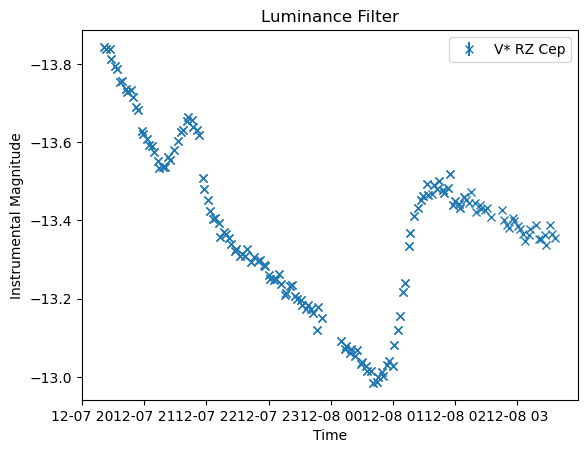

In [67]:
#plot example stars
img_num_star = []
inst_mag_star = []
mag_err = []
date_time_star = []
exp_time_star = []
corrected_mag = []
corrected_err = []

star_name = 'V* RZ Cep'

#All stars good for 2023_01_23
#Iffy stars for 2023_02_23:
# TYC 4273-659-1
# TYC 4273-858-1
# Ross  214
# Gaia DR2 2211583698432680064
# TYC 4273-673-1 kinda
# TYC 4273-307-1
# TYC 4273-1038-1
# UCAC4 776-050859
# TYC 4273-822-1
# Gaia DR3 2211625479874273536
# UCAC4 776-050768
# TYC 4273-900-1
# TYC 4273-609-1
# Gaia DR3 2211625484173740928
# 1RXS J223959.9+643330
# UCAC4 774-052557
# NVSS J224054+645420

for obs_data in star_properties:
    if star_name in obs_data:
        img_num_star.append(obs_data[star_name]['img_number'])
        inst_mag_star.append(obs_data[star_name]['instrumental_mag'])
        mag_err.append(abs(obs_data[star_name]['mag_error']))
        date_time_star.append(obs_data[star_name]['date_time'])
        exp_time_star.append(obs_data[star_name]['exp_time'])
        
        if isinstance(obs_data[star_name]['corr_mag'], tuple):
            corrected_mag.append(obs_data[star_name]['corr_mag'][0])
        else:
            corrected_mag.append(obs_data[star_name]['corr_mag'])
        
date_time_star = pd.to_datetime(date_time_star)
#print(mag_err)

plt.errorbar(date_time_star, corrected_mag, yerr=mag_err, marker='x', ls='None', label=star_name)
plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [68]:
'''
#define a correction factor function to apply to each star individually
def get_correction_factors(magnitudes: list[float]) -> list[float]:
    #set reference point as first image data set
    ref_mag = magnitudes[0]
    #set the first correction factor associated with the first image data set to 1
    corr_factors = [1]
    #iterate over all image data sets, excluding the first one
    for mag_current_image in magnitudes[1:]:
        #append the corrected factors array with a correction factor for each image
        corr_factors.append(ref_mag / mag_current_image)
    #return the correction factors for this star
    return corr_factors


#save list of star names without star of interest
names_without_cep = star_properties[0].keys() - {'V* RZ Cep'}
#set up a new empty dictionary conatining all the star names without rz cep
star_datapoints = {key: [] for key in names_without_cep}

#for each image in the star_properties list of dicts of dicts
for image in star_properties:
    #iterate over the star names without rz cep
    for star_name in names_without_cep:
        if star_name in image:
            if isinstance(image[star_name]['corr_mag'], tuple):
                star_datapoints[star_name].append(image[star_name]['corr_mag'][0])
            else:
                star_datapoints[star_name].append(image[star_name]['corr_mag'])
        else:
            star_datapoints[star_name].append(star_datapoints[star_name]['corr_mag'][0])


#create a list of lists containing all image by image correction factors for each individual star
imgbyimg_factors = [get_correction_factors(val) for key, val in star_datapoints.items()]

# print(imgbyimg_factors[0])
#set up list of lists containing the mean and std of each image's correction factors
condensed_correction_factors = [
    [
        np.mean([row[colnum] for row in imgbyimg_factors]),
        np.std([row[colnum] for row in imgbyimg_factors])
    ] for colnum, _ in enumerate(imgbyimg_factors[0])
]
# condensed_correction_factors = []
# for row in imgbying_factors:
    
    
# print(condensed_correction_factors)
#print(len(condensed_correction_factors))
#first sq bracket changes image, second square bracket changes between mean and standard deviation
#print(condensed_correction_factors[0][1])
'''
pass

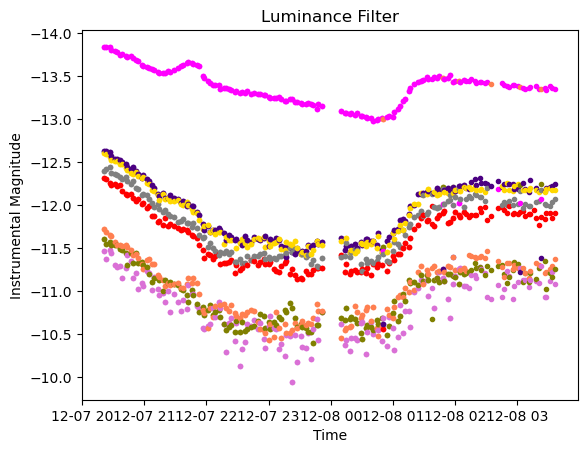

In [69]:
#plot all stars
colour_array = ["red", 'orchid', 'olive', 'indigo', 'coral', 'fuchsia', 'grey', 'gold', 'violet', 'navy', 'indigo', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'gold', 'chocolate', 'beige', 'black', 'navy', 'magenta', 'teal', 'orangered', 'darkblue', 'brown', 'aquamarine', 'beige']

for obs_data in range(len(star_properties)):
    for colour_idx, star_name in enumerate(star_properties[obs_data]):
        img_num = []
        inst_mag = []
        date_time = []
        exp_time = []
        mag_err = []
        corrected_mag = []
        
        img_num.append(star_properties[obs_data][star_name]['img_number'])
        inst_mag.append(star_properties[obs_data][star_name]['instrumental_mag'])
        mag_err.append(abs(star_properties[obs_data][star_name]['mag_error']))
        date_time.append(star_properties[obs_data][star_name]['date_time'])
        exp_time.append(star_properties[obs_data][star_name]['exp_time'])
        
        if len(corrected_mag) == 0:
            corrected_mag.append(star_properties[obs_data][star_name]['corr_mag'])
        else:
            corrected_mag.append(star_properties[obs_data][star_name]['corr_mag'][0])
        
        date_time = pd.to_datetime(date_time)
        plt.errorbar(date_time, corrected_mag, yerr=mag_err, marker='.', ls='None', label=star_name, color=colour_array[colour_idx % 28])
        del img_num, inst_mag, mag_err, date_time, exp_time, corrected_mag
    
plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
# plt.legend()
plt.show()

In [70]:
def convert_df_to_mag_dict(df: pd.DataFrame, corr_mag_name_df) -> dict:
    """
    Converts a star dataframe (read in via pd.read_csv) to a dictionary of star names to magnitudes
    """
    ref_dict = {}
    for idx, row in df.iterrows():
        star_name = row[star_id_name]
        #checks for valid magnitudes (i.e. not from negative fluxes)
        if row[corr_mag_name_df] != np.nan and not math.isnan(row[corr_mag_name_df]) and star_name not in ref_dict:
            #set up new row in the star_properties dictionary (index i to be associated with dataframe/image i) to save
            #the star name and its associated image number, magnitude, date/time and exposure time
            ref_dict[star_name] = float(row[corr_mag_name_df])
            #print(row[corr_mag_name_df], star_name)
    return ref_dict

def find_removal_candidates(dataset, threshold):
    point_changes = {}
    prev_point = {}
    for image in dataset:
        for star_name, props in image.items():
            if star_name in prev_point:
                if isinstance(props['corr_mag'], tuple):
                    res = abs(prev_point[star_name] - props["corr_mag"][0])
                else:
                    res = abs(prev_point[star_name] - props["corr_mag"])
                    
                if star_name in point_changes:
                    point_changes[star_name].append(res)
                else:
                    point_changes[star_name] = [res]
            
            if isinstance(props['corr_mag'], tuple):
                prev_point[star_name] = props["corr_mag"][0]
            else:
                prev_point[star_name] = props["corr_mag"]
    
#     print(point_changes)
    change_means = {}
    for key, val in point_changes.items():
        change_means[key] = np.mean(val)
    
    print(change_means)
        
    return [key for key, val in change_means.items() if val > threshold]

def remove_stars(names_of_stars_to_remove, dataset):
    for image in dataset:
        for name in names_of_stars_to_remove:
            if name in image:
                del image[name]

def get_correction_factor_img_by_img(
    dict_list: list[dict[dict]], 
    reference_df: pd.DataFrame, 
    corrected_magnitude_name) -> list[list[float, float]]:
    
    final_correction_factors: list[list[float, float]] = []
    temp_correction_factors: list = []
    reference_for_stars = convert_df_to_mag_dict(reference_df, 'corrected_mag')

    #print(reference_for_stars)
    
    for image in dict_list:
        star_in_both = (reference_for_stars.keys() & image.keys()) - {'V* RZ Cep'}
        star_in_im_not_ref = (image.keys() - reference_for_stars.keys()) - {'V* RZ Cep'}

        temp_correction_factors = []
        for star_name in star_in_both:
            if isinstance(image[star_name][corrected_magnitude_name], tuple):
                temp_correction_factors.append(reference_for_stars[star_name] -
                                              image[star_name][corrected_magnitude_name][0])
            else:
                temp_correction_factors.append(reference_for_stars[star_name] -
                                              image[star_name][corrected_magnitude_name])

        for star_name in star_in_im_not_ref:
            if isinstance(image[star_name][corrected_magnitude_name], tuple):
                reference_for_stars[star_name] = image[star_name][corrected_magnitude_name][0]
            else:
                reference_for_stars[star_name] = image[star_name][corrected_magnitude_name]
            
            temp_correction_factors.append(np.mean(temp_correction_factors))

        final_correction_factors.append([np.mean(temp_correction_factors), 
                                         np.std(temp_correction_factors)/np.sqrt(len(temp_correction_factors))])
        
    return final_correction_factors

In [71]:
ref_df = pd.read_csv(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Matched Stars/Luminance/star_Light_Luminance_10_secs_001_reduced_matched.csv')
ref_df['corrected_mag']

# print(correction_factors)

0     -14.131119
1     -13.071510
2     -13.346190
3     -12.721426
4     -12.467651
         ...    
145    -8.596713
146    -8.691852
147    -8.815328
148    -9.267526
149    -9.013960
Name: corrected_mag, Length: 150, dtype: float64

In [74]:
removal_stars_maybe = find_removal_candidates(star_properties, 0.03)
print(removal_stars_maybe)
remove_stars(removal_stars_maybe, star_properties)

{'IRAS 22364+6432': 0.025379514250685492, 'Gaia DR2 2211583698432680064': 0.0795140378875219, 'TYC 4273-307-1': 0.043193761466380626, '2MASS J22405245+6505370': 0.02292240385605235, 'GSH 109+06-32': 0.03873802980700448, 'V* RZ Cep': 0.010337094038493621, '2MASS J22420892+6508103': 0.024210594415748573, 'LSPM J2241+6501': 0.0237400076176381}
['Gaia DR2 2211583698432680064', 'TYC 4273-307-1', 'GSH 109+06-32']


In [75]:
correction_factors = get_correction_factor_img_by_img(star_properties, ref_df, 'corr_mag')
print(correction_factors)

[[0.31514377484946676, 0.15790295623588163], [0.31514377484946676, 0.15790295623588163], [0.31655542418863947, 0.16314891594146055], [0.31655542418863947, 0.16314891594146055], [0.3001980576034069, 0.17654044058396556], [0.3001980576034069, 0.17654044058396556], [0.2560589829074793, 0.16561386437771525], [0.2560589829074793, 0.16561386437771525], [0.24417987060701973, 0.16341773849749208], [0.24417987060701973, 0.16341773849749208], [0.23520830929990133, 0.16591279374268192], [0.23520830929990133, 0.16591279374268192], [0.22062791809246018, 0.15922198507010513], [0.22062791809246018, 0.15922198507010513], [0.18898930638985956, 0.16830664273851859], [0.18898930638985956, 0.16830664273851859], [0.16912642184906623, 0.17699126191708223], [0.16912642184906623, 0.17699126191708223], [0.14155886125224315, 0.17198746033716103], [0.14155886125224315, 0.17198746033716103], [0.11691501317860187, 0.16278559447753388], [0.11691501317860187, 0.16278559447753388], [0.12163608110964974, 0.17503640714

In [76]:
#print(star_properties)

#iterate over star_properties to correct all the magnitudes
for image_number, dictionary in enumerate(star_properties):
    #iterate over each star name
    for star_name in dictionary.keys():
        #apply correction factor to each magnitude for each star
        if isinstance(star_properties[image_number][star_name]['corr_mag'], tuple) == True:
            intermediate = list(star_properties[image_number][star_name]['corr_mag'])
            for i in range(len(intermediate)):
                intermediate[i] = correction_factors[image_number][0] + intermediate[0]
            star_properties[image_number][star_name]['corr_mag'] = intermediate[0]
#             star_properties[image_number][star_name]['corr_mag'][0] *= condensed_correction_factors[image_number][0]
        else:
            star_properties[image_number][star_name]['corr_mag'] = correction_factors[image_number][0] + star_properties[image_number][star_name]['corr_mag']
        
        star_properties[image_number][star_name]['mag_error'] += correction_factors[image_number][1]

print(star_properties)

#no need for a second iteration, as correction factors all come out to approx 1 with std of 2-3 mags smaller

[{'IRAS 22364+6432': {'img_number': 1, 'instrumental_mag': -14.063408765999794, 'corr_mag': -12.00083998031028, 'mag_error': 0.15652275141897792, 'date_time': '2022-12-07T20:21:36.898', 'exp_time': 5.0}, '2MASS J22405245+6505370': {'img_number': 1, 'instrumental_mag': -14.377397757172387, 'corr_mag': -12.314828971482875, 'mag_error': 0.15681833695490643, 'date_time': '2022-12-07T20:21:36.898', 'exp_time': 5.0}, 'V* RZ Cep': {'img_number': 1, 'instrumental_mag': -15.590399797041314, 'corr_mag': -13.5278310113518, 'mag_error': 0.15743565862436124, 'date_time': '2022-12-07T20:21:36.898', 'exp_time': 5.0}, '2MASS J22420892+6508103': {'img_number': 1, 'instrumental_mag': -14.145512538539071, 'corr_mag': -12.082943752849559, 'mag_error': 0.15660384311589454, 'date_time': '2022-12-07T20:21:36.898', 'exp_time': 5.0}, 'LSPM J2241+6501': {'img_number': 1, 'instrumental_mag': -14.35553351016906, 'corr_mag': -12.292964724479544, 'mag_error': 0.15679766865068012, 'date_time': '2022-12-07T20:21:36.8

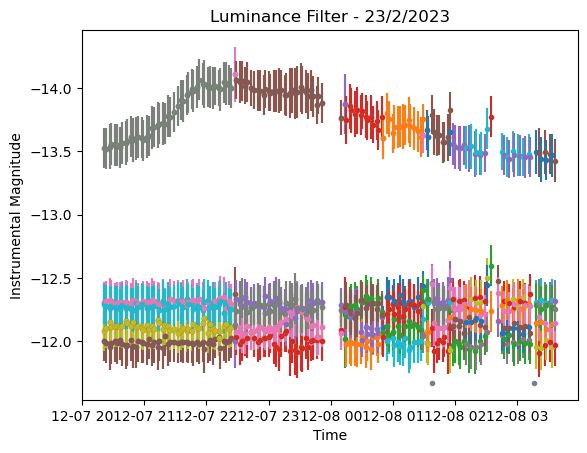

In [77]:
#plot all stars
for obs_data in range(len(star_properties)):
    for star_name in star_properties[obs_data]:
        img_num = []
        inst_mag = []
        mag_err = []
        date_time = []
        exp_time = []
        corrected_mag = []
        
        img_num.append(star_properties[obs_data][star_name]['img_number'])
        inst_mag.append(star_properties[obs_data][star_name]['instrumental_mag'])
        mag_err.append(abs(star_properties[obs_data][star_name]['mag_error']))
        date_time.append(star_properties[obs_data][star_name]['date_time'])
        exp_time.append(star_properties[obs_data][star_name]['exp_time'])
        
        if len(corrected_mag) == 0:
            corrected_mag.append(star_properties[obs_data][star_name]['corr_mag'])
        else:
            corrected_mag.append(star_properties[obs_data][star_name]['corr_mag'][0])
        
        date_time = pd.to_datetime(date_time)
        plt.errorbar(date_time, corrected_mag, yerr=mag_err, marker='.', ls='None', label=star_name)
    
plt.title('Luminance Filter - 23/2/2023')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
#plt.legend()
plt.show()

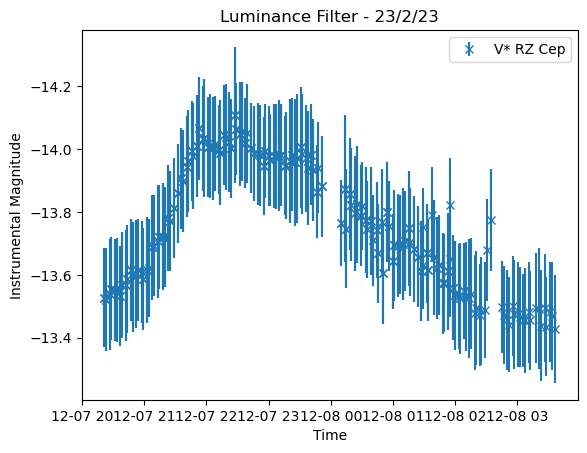

In [78]:
#plot example stars
img_num_star = []
inst_mag_star = []
mag_err_star = []
date_time_star = []
exp_time_star = []
corrected_mag = []

star_name = 'V* RZ Cep'

for obs_data in star_properties:
    if star_name in obs_data:
        img_num_star.append(obs_data[star_name]['img_number'])
        inst_mag_star.append(obs_data[star_name]['instrumental_mag'])
        mag_err_star.append(abs(obs_data[star_name]['mag_error']))
        date_time_star.append(obs_data[star_name]['date_time'])
        exp_time_star.append(obs_data[star_name]['exp_time'])
        

        corrected_mag.append(obs_data[star_name]['corr_mag'])

date_time_star = pd.to_datetime(date_time_star)

plt.errorbar(date_time_star, corrected_mag, yerr=mag_err_star, marker='x', ls='None', label=star_name)
plt.title('Luminance Filter - 23/2/23')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [79]:
#use ap stats error or sqrt counts

df_curve = pd.DataFrame(data=(corrected_mag, mag_err_star, date_time_star))
df_curve = df_curve.T
df_curve.columns = ['corrected_magnitude', 'magnitude_error', 'date_time']
df_curve.to_csv(final_csv_path / final_csv_name)

In [80]:
df_curve

,corrected_magnitude,magnitude_error,date_time
0,-13.527831,0.157436,2022-12-07 20:21:36.898
1,-13.527831,0.157436,2022-12-07 20:21:36.898
2,-13.521467,0.162679,2022-12-07 20:23:10.168
3,-13.521467,0.162679,2022-12-07 20:23:10.168
4,-13.537658,0.176065,2022-12-07 20:26:47.376
...,...,...,...
278,-13.494127,0.171868,2022-12-08 03:26:24.390
279,-13.435242,0.158071,2022-12-08 03:27:56.264
280,-13.480732,0.158699,2022-12-08 03:31:34.398
281,-13.46854,0.172639,2022-12-08 03:33:04.554
